In [1]:
import torch, detectron2

from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import  get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_test_loader, build_detection_train_loader, DatasetMapper
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2 import model_zoo
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.data.detection_utils import read_image
import detectron2.data.transforms as T
from detectron2.data.datasets import register_coco_instances, load_coco_json

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

import data_loaders

In [2]:
#Directorio donde se encuentran las imágenes originales
directorio = 'frames/'
frames = (sorted(os.listdir(directorio), key=lambda x: int(x.split(".")[0])))
# Itera sobre todas las imágenes en el directorio
for i, nombre_archivo in enumerate(frames):
#    # Construye el nuevo nombre de archivo con el formato deseado
    nuevo_nombre = f"{i+1:05d}.jpg"
    # Renombra el archivo
    #os.rename(os.path.join(directorio, nombre_archivo), os.path.join(directorio, nuevo_nombre))

print("Renombrado completado.")

Renombrado completado.


In [5]:
class Detector:
    
    def __init__(self, model_type = "OD", outpath:str="./random"):
        self.cfg = get_cfg()
        
        #Load model config and pretrained model
        if model_type == "OD":
            self.cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
            self.cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")      
            
            
        elif model_type == "IS":
            
            self.cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
            self.cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")      
            
        elif model_type == "KP":
            
            self.cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
            self.cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")      
            
                
        self.cfg.OUTPUT_DIR =   os.path.join(outpath, "23_no_shuffled")   
        #self.cfg.defrost()

        self.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
        self.cfg.MODEL.DEVICE = "cuda"
        self.cfg.SOLVER.IMS_PER_BATCH = 4
        self.cfg.SOLVER.CHECKPOINT_PERIOD = 250
        self.cfg.SOLVER.MAX_ITER = 500
        #self.cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

        #self.cfg.SOLVER.IMS_PER_BATCH = 4
        #self.cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64

        self.__loader_mapping = loader_mapping = {
                                                'first': data_loaders.load_sequential_hold_out,
                                                'random': data_loaders.load_random_data,
                                                '13': data_loaders.load_13,
                                                '12': data_loaders.load_12,
                                                '23': data_loaders.load_23
                                            }
        
        self._datasets = {"train": None, "val": None}
        self._metadata = { "train": None, "val": None }


    def prepare_dataset(self, kind:str = "first", kfolds:bool=False, select_folds:str="12"):
        self.loader = self.__loader_mapping.get(kind if not kfolds else select_folds, None)


        if self.loader is None:
            raise ValueError("Invalid split or folds value")

        for data_type in ['train', 'val']:
            static = set(["1","2","3"])
            query  = set(list(select_folds))
            test_name = list(static  - query)[-1]
            
            if data_type == "val":
                dataset_name = os.path.join("datafolds", f"{data_type}_{kind if not kfolds else test_name}")
                self.cfg.DATASETS.TEST = (f"{data_type}_dataset",)
           
            else:
                dataset_name = os.path.join("datafolds", f"{data_type}_{kind if not kfolds else select_folds}")
                self.cfg.DATASETS.TRAIN = (f"{data_type}_dataset",)
            
            #register_coco_instances(f"{data_type}_dataset", {}, dataset_name+".json", "./frames")
            print(data_type)
            print(dataset_name+".json")
            self._metadata[data_type] = MetadataCatalog.get(f"{data_type}_dataset").set(thing_classes=["car", "bike"])            
            self._datasets[data_type] = DatasetCatalog.register(f"{data_type}_dataset", lambda d=data_type: self.loader(data_type) )

        os.makedirs(self.cfg.OUTPUT_DIR, exist_ok=True)

    def fit_(self):

        trainer = DefaultTrainer(self.cfg)
        #DefaultTrainer.build_train_loader = lambda: dataloader

        trainer.resume_or_load(resume=False)

        trainer.train()



        

     

### Define and Train model with custom dataset

In [6]:
detector = Detector(model_type="OD", outpath="./23_no_shuffle_keep")
detector.prepare_dataset(kind = "23", kfolds=True, select_folds="23")

train
datafolds/train_23.json
val
datafolds/val_1.json


In [7]:
detector.fit_()

[03/06 02:03:17 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/home/cboned/miniconda3/envs/detectron/lib/python3.9/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[03/06 02:03:38 d2.utils.events]:  eta: 0:08:04  iter: 19  total_loss: 0.9277  loss_cls: 0.2981  loss_box_reg: 0.5612  loss_rpn_cls: 0.01959  loss_rpn_loc: 0.04867    time: 0.9790  last_time: 1.0147  data_time: 0.0229  last_data_time: 0.0095   lr: 0.00077924  max_mem: 6212M
[03/06 02:03:58 d2.utils.events]:  eta: 0:07:45  iter: 39  total_loss: 0.5615  loss_cls: 0.1541  loss_box_reg: 0.365  loss_rpn_cls: 0.01159  loss_rpn_loc: 0.02979    time: 0.9846  last_time: 0.9067  data_time: 0.0088  last_data_time: 0.0089   lr: 0.0015784  max_mem: 6212M
[03/06 02:04:18 d2.utils.events]:  eta: 0:07:26  iter: 59  total_loss: 0.4514  loss_cls: 0.1221  loss_box_reg: 0.2867  loss_rpn_cls: 0.00422  loss_rpn_loc: 0.02448    time: 0.9877  last_time: 0.9057  data_time: 0.0095  last_data_time: 0.0077   lr: 0.0023776  max_mem: 6212M
[03/06 02:04:38 d2.utils.events]:  eta: 0:07:07  iter: 79  total_loss: 0.4052  loss_cls: 0.1011  loss_box_reg: 0.2567  loss_rpn_cls: 0.005243  loss_rpn_loc: 0.02041    time: 0.99

In [9]:
DatasetCatalog.get("val_dataset")

[{'id': 1415,
  'license': 1,
  'file_name': 'frames/01415.jpg',
  'height': 1080,
  'width': 1920,
  'date_captured': None,
  'image_id': 1415,
  'annotations': [{'id': 3257,
    'image_id': 1415,
    'category_id': 0,
    'bbox': [912.46, 968.08, 457.74, 111.91999999999996],
    'segmentation': [],
    'keypoints': [],
    'num_keypoints': 0,
    'score': 1,
    'area': 51230.26079999998,
    'iscrowd': 0,
    'bbox_mode': 1},
   {'id': 6121,
    'image_id': 1415,
    'category_id': 0,
    'bbox': [558.36, 94.45, 105.13, 74.86],
    'segmentation': [],
    'keypoints': [],
    'num_keypoints': 0,
    'score': 1,
    'area': 7870.0318,
    'iscrowd': 0,
    'bbox_mode': 1},
   {'id': 8262,
    'image_id': 1415,
    'category_id': 0,
    'bbox': [573.7, 72.89, 87.70999999999992, 72.16000000000001],
    'segmentation': [],
    'keypoints': [],
    'num_keypoints': 0,
    'score': 1,
    'area': 6329.153599999995,
    'iscrowd': 0,
    'bbox_mode': 1},
   {'id': 10403,
    'image_id': 14

In [8]:
import yaml
# Save the configuration to a config.yaml file
# Save the configuration to a config.yaml file
config_yaml_path = "configs/config_32_no_shuffle.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(detector.cfg, file)
     

In [8]:
detector._metadata["train"]

namespace(name='datafolds/train_12', thing_classes=['car', 'bike'])

In [12]:
detector._datasets["train"]

### Define the dataloaders to create the videos and evaluate

In [9]:
train_loader = DatasetCatalog.get("train_dataset")
train_metadata = MetadataCatalog.get("train_dataset")


val_loader = DatasetCatalog.get("val_dataset")
val_metadata = MetadataCatalog.get("val_dataset")

In [10]:
detector.cfg.OUTPUT_DIR

'./23_no_shuffle_keep/23_no_shuffled'

[03/06 00:48:14 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./first_no_shuffle_keep/faster_no_shuffled/model_final.pth ...


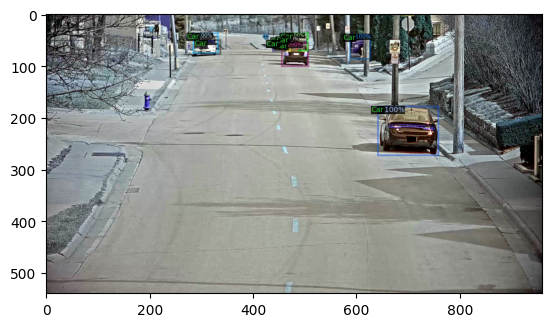

In [29]:
import random
from detectron2.utils.visualizer import ColorMode

detector.cfg.MODEL.WEIGHTS = os.path.join(detector.cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
detector.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(detector.cfg)

plot_path = os.path.join("plot_results", "first_no_shuffle")

os.makedirs(plot_path, exist_ok=True)

for d in (val_loader): 
    for i in d:#select number of images for display
        im = cv2.imread(i["file_name"])
        outputs = predictor(im)
        
        v = Visualizer(im[:, :, ::-1],
                    metadata=val_metadata,
                    scale=0.5,
                    instance_mode=ColorMode.IMAGE    # remove the colors of unsegmented pixels. This option is only available for segmentation models
        )
        instances = outputs["instances"]
        out = v.draw_instance_predictions(instances.to("cpu"))
        boxes = v._convert_boxes(outputs["instances"].pred_boxes.to('cpu')).squeeze()

        for box in boxes:
            out = v.draw_text(f"Car", (box[0], box[1]))
            
        plt.imshow(out.get_image()[:, :, ::-1])
        cv2.imwrite(plot_path+f"/{i['file_name'].split('/')[-1]}", out.get_image()[:, :, ::-1])


### Evaluate model

In [11]:
detector.cfg.MODEL.WEIGHTS = os.path.join(detector.cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
detector.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(detector.cfg)

[03/06 02:15:28 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./23_no_shuffle_keep/23_no_shuffled/model_final.pth ...


In [12]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("val_dataset", output_dir="./output")
val_loader = build_detection_test_loader(detector.cfg, "val_dataset")


[03/06 02:15:31 d2.evaluation.coco_evaluation]: Trying to convert 'val_dataset' to COCO format ...
[03/06 02:15:31 d2.data.datasets.coco]: Converting annotations of dataset 'val_dataset' to COCO format ...)
[03/06 02:15:31 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[03/06 02:15:32 d2.data.datasets.coco]: Conversion finished, #images: 707, #annotations: 7399
[03/06 02:15:32 d2.data.datasets.coco]: Caching COCO format annotations at './output/val_dataset_coco_format.json' ...
[03/06 02:15:32 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/06 02:15:32 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[03/06 02:15:32 d2.data.common]: Serializing 707 elements to byte tensors and concatenating them all ...
[03/06 02:15:32 d2.data.common]: Serialized dataset takes 0.82 MiB


In [13]:
(inference_on_dataset(predictor.model, val_loader , evaluator))

[03/06 02:15:34 d2.evaluation.evaluator]: Start inference on 707 batches
[03/06 02:15:36 d2.evaluation.evaluator]: Inference done 11/707. Dataloading: 0.0008 s/iter. Inference: 0.1000 s/iter. Eval: 0.0003 s/iter. Total: 0.1011 s/iter. ETA=0:01:10
[03/06 02:15:41 d2.evaluation.evaluator]: Inference done 60/707. Dataloading: 0.0014 s/iter. Inference: 0.1004 s/iter. Eval: 0.0003 s/iter. Total: 0.1021 s/iter. ETA=0:01:06
[03/06 02:15:46 d2.evaluation.evaluator]: Inference done 109/707. Dataloading: 0.0014 s/iter. Inference: 0.1006 s/iter. Eval: 0.0003 s/iter. Total: 0.1023 s/iter. ETA=0:01:01
[03/06 02:15:51 d2.evaluation.evaluator]: Inference done 158/707. Dataloading: 0.0013 s/iter. Inference: 0.1006 s/iter. Eval: 0.0003 s/iter. Total: 0.1022 s/iter. ETA=0:00:56
[03/06 02:15:56 d2.evaluation.evaluator]: Inference done 207/707. Dataloading: 0.0014 s/iter. Inference: 0.1006 s/iter. Eval: 0.0003 s/iter. Total: 0.1023 s/iter. ETA=0:00:51
[03/06 02:16:01 d2.evaluation.evaluator]: Inference do

OrderedDict([('bbox',
              {'AP': 82.00272154450771,
               'AP50': 98.51442692763926,
               'AP75': 96.85492612932295,
               'APs': 84.95049504950495,
               'APm': nan,
               'APl': nan,
               'AP-car': 88.18298474456753,
               'AP-bike': 75.82245834444791})])